In [1]:
# Standard imports
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
%matplotlib inline

from time import time

# PyREx imports
import pyrex
from pyrex.signals import SlowAskaryanSignal, FastAskaryanSignal, ThermalNoise

In [2]:
# Signal plotting helper function
def plot_sig(signal, alternate_values=None, zoom=None, figsize=(6,4)):
    plt.figure(figsize=figsize)
    if alternate_values is not None:
        values = alternate_values
    else:
        values = signal.values
    if zoom is not None:
        ts = []
        vs = []
        for t,v in zip(signal.times,values):
            if t<zoom[0]:
                continue
            elif t>zoom[1]:
                break
            ts.append(t)
            vs.append(v)
        plt.plot(np.array(ts)*1e9, vs)
    else:
        plt.plot(signal.times*1e9, values)
    plt.xlabel("Time (ns)")

## Jump to:

[Test Slow Askaryan Pulses](#slow_askaryan_pulses)

[Test Faster Askaryan Pulses](#fast_askaryan_pulses)

[Test Askaryan Pulse Angles](#askaryan_angles)

[Test Thermal (Rayleigh) Noise](#thermal_noise)

[Test Dipole Antenna](#dipole_antenna)

[Test ReflectedPathFinder Logic](#reflected_logic)

[Test ReflectedPathFinder Paths](#reflected_path)

<a id='slow_askaryan_pulses'></a>
# Test Slow Askaryan Pulses

Make signal object

In [3]:
times = np.linspace(0, 100e-9, 10001)
n = 1.75
theta_c = np.arcsin(np.sqrt(1 - 1/n**2))
angle = theta_c - 0.3*np.pi/180 # radians
# angle = 45*np.pi/180
print("angle =",angle*180/np.pi,"degrees")
energy = 3e6 # TeV
t0 = 25e-9 # seconds
start_time = time()
ask = SlowAskaryanSignal(times, energy=energy*1e3, theta=angle, t0=t0, n=n)
end_time = time()
print("Generating an Askaryan pulse with",len(times),"points took", end_time-start_time, "seconds")
print(round((end_time-start_time)/len(times)*1000,2),"ms per time point")

angle = 54.850095421 degrees
Generating an Askaryan pulse with 10001 points took 102.96960306167603 seconds
10.3 ms per time point


First make sure that the longitudinal shower profile makes sense

Integral:  2.29306854455e-09


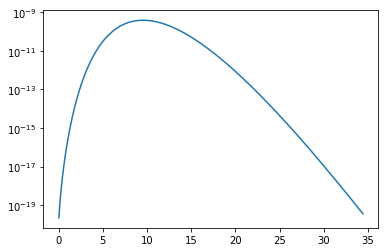

In [4]:
z_min = 0
z_max = 2.5*ask.max_length()
n_z = 1000
z_vals, dz = np.linspace(z_min, z_max, n_z, endpoint=False, retstep=True)
Q = np.zeros(n_z)
for i, z in enumerate(z_vals):
    Q[i] = ask.charge_profile(z)
plt.semilogy(z_vals, Q)
print("Integral: ", np.trapz(Q, dx=dz))

Next check the RAC distribution

Should peak around 1e-5 with the normalization factor applied. Width should be about .5 ns at 1e-6 and 1 ns at 1e-7

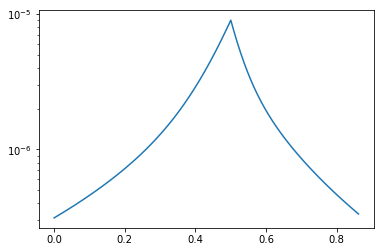

In [5]:
t = 25.5e-9
z_to_t = -(1 - n*np.cos(angle))/3e8
RA_C = np.zeros(n_z)
for j, z in enumerate(z_vals):
    RA_C[j] = ask.RAC(t - t0 - z*z_to_t)
normalization = 1e8 / energy
plt.semilogy(z_vals*z_to_t*1e9, -1*RA_C*normalization)

Now check the vector potential

For a 3 EeV shower 0.3 degrees off the Cherenkov angle, expect a peak around 7e-8 volt-seconds and a width of about 3 ns

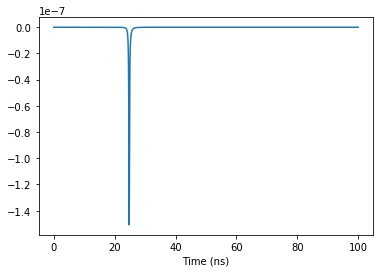

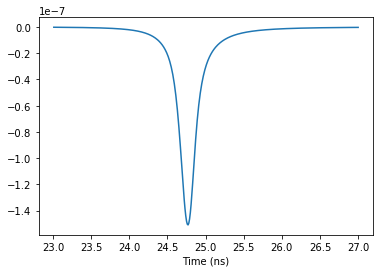

In [6]:
plot_sig(ask, alternate_values=ask.vector_potential)
plot_sig(ask, alternate_values=ask.vector_potential, zoom=[23e-9,27e-9])

Finally, check that the waveform looks correct

For a 3 EeV shower 0.3 degrees of the Cherenkov angle, expect an amplitude of about 200 volts (when multiplied by R, assumed to be 1 meter in the signal code anyway) and a width of about 1 ns

832.621044624


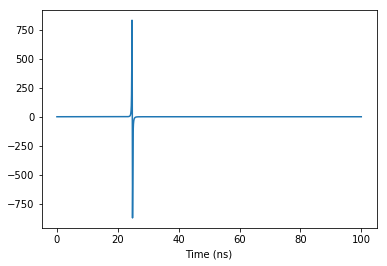

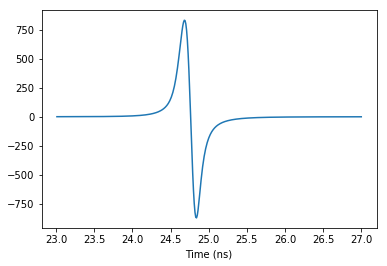

In [7]:
plot_sig(ask)
plot_sig(ask, zoom=[23e-9,27e-9])
# plt.figure()
# plt.plot(np.linspace(0,100e-9,5001),scipy.signal.resample(ask.values,5001))
print(max(ask.values))

<a id='fast_askaryan_pulses'></a>
# Test Faster Askaryan Pulses

Make signal object

In [8]:
times = np.linspace(0, 100e-9, 10001, endpoint=True)
n = 1.75
theta_c = np.arcsin(np.sqrt(1 - 1/n**2))
angle = theta_c - 0.3*np.pi/180 # radians
# angle = 45 * np.pi/180
print("angle =",angle*180/np.pi,"degrees")
energy = 3e6 # TeV
t0 = 25e-9 # seconds
start_time = time()
ask = FastAskaryanSignal(times, energy=energy*1e3, theta=angle, t0=t0, n=n)
end_time = time()
print("Generating an Askaryan pulse with",len(times),"points took", end_time-start_time, "seconds")
print(round((end_time-start_time)/len(times)*1e6,2),"microseconds per time point")

angle = 54.850095421 degrees
Generating an Askaryan pulse with 10001 points took 0.10533499717712402 seconds
10.53 microseconds per time point


Check the shower profile and RAC distributions, as well as their convolution

z_to_t = -2.50195760286e-11
dz = -0.399687028612
max_length = 13.785557084
n_Q = 86
LQ_tot = -2.29306854452e-09


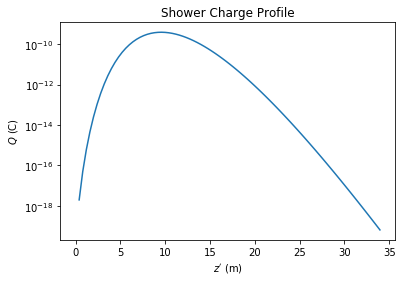

n_RAC = 9916
t_min = -2.5e-08
t_max = 7.415e-08


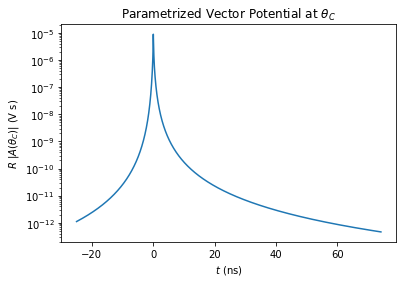

10001
10001
10001 == 10001 ?


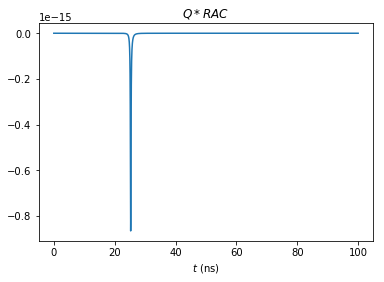

In [9]:
# Conversion factor for z in RAC
z_to_t = (1 - n*np.cos(angle))/3e8
print("z_to_t =",z_to_t)

dt = times[1] - times[0]
dz = dt / z_to_t
dz_factor = 1
dz /= dz_factor
print("dz =",dz)

z_max = 2.5*ask.max_length()
print("max_length =",ask.max_length())
n_Q = int(z_max/np.abs(dz))
print("n_Q =",n_Q)
z_Q_vals = np.arange(n_Q) * np.abs(dz)
Q = np.zeros(n_Q)
for i, z in enumerate(z_Q_vals):
    Q[i] = ask.charge_profile(z)
LQ_tot = np.trapz(Q, dx=dz)
print("LQ_tot =", LQ_tot)

plt.semilogy(z_Q_vals, Q)
plt.title("Shower Charge Profile")
plt.xlabel(r"$z^\prime$ (m)")
plt.ylabel(r"$Q$ (C)")
plt.show()

n_extra_before = 0
n_extra_after = 0
n_RAC = len(times)*dz_factor + 1 - n_Q + n_extra_before + n_extra_after
print("n_RAC =",n_RAC)
t_RAC_vals = np.arange(n_RAC)*dz*z_to_t + times[0] - t0 - n_extra_before*dz*z_to_t
print("t_min =",t_RAC_vals[0])
print("t_max =",t_RAC_vals[-1])
RA_C = np.zeros(n_RAC)
for i, t in enumerate(t_RAC_vals):
    RA_C[i] = ask.RAC(t)

normalization = 1e8 / energy
plt.semilogy(t_RAC_vals*1e9, -1*RA_C*normalization)
plt.title(r"Parametrized Vector Potential at $\theta_C$")
plt.xlabel(r"$t$ (ns)")
plt.ylabel(r"$R\ |A(\theta_C)|$ (V s)")
plt.show()


conv = scipy.signal.convolve(Q, RA_C, mode='full')
print(len(conv))
conv = conv[::dz_factor]
print(len(conv))
if n_extra_after>0:
    conv = conv[:-n_extra_after]
if n_extra_before>0:
    conv = conv[n_extra_before:]
print(len(times),"==",len(conv),"?")
plt.plot(times*1e9, conv)
plt.title(r"$Q * RAC$")
plt.xlabel(r"$t$ (ns)")
plt.show()

Now check the vector potential

For a 3 EeV shower 0.3 degrees off the Cherenkov angle, expect a peak around 7e-8 volt-seconds and a width of about 3 ns

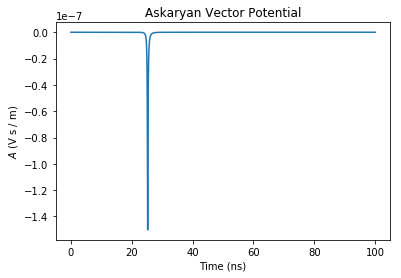

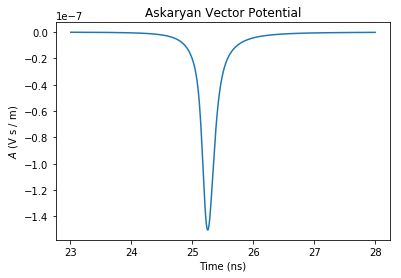

In [10]:
plot_sig(ask, alternate_values=ask.vector_potential)
plt.title("Askaryan Vector Potential")
plt.ylabel(r"$A$ (V s / m)")
plot_sig(ask, alternate_values=ask.vector_potential, zoom=[23e-9,28e-9])
plt.title("Askaryan Vector Potential")
plt.ylabel(r"$A$ (V s / m)")

Finally, check that the waveform looks correct

For a 3 EeV shower 0.3 degrees of the Cherenkov angle, expect an amplitude of about 200 volts (when multiplied by R, assumed to be 1 meter in the signal code anyway) and a width of about 2 ns

973.315442901


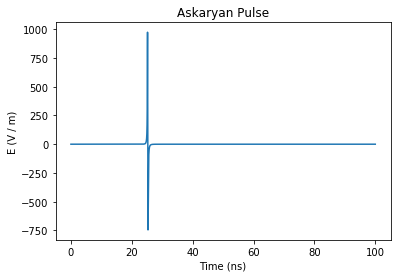

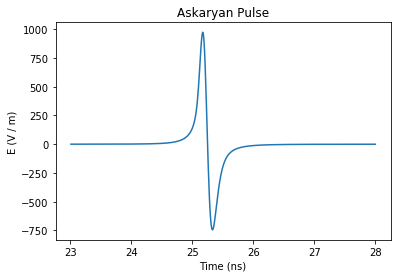

In [11]:
plot_sig(ask)
plt.title("Askaryan Pulse")
plt.ylabel("E (V / m)")
plot_sig(ask, zoom=[23e-9,28e-9])
plt.title("Askaryan Pulse")
plt.ylabel("E (V / m)")
print(max(ask.values))

<a id="askaryan_angles"></a>
# Test Askaryan Pulse Angles

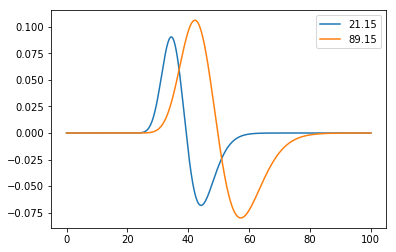

In [32]:
times = np.linspace(0, 100e-9, 10001, endpoint=True)
n = 1.75
theta_c = np.arcsin(np.sqrt(1 - 1/n**2))

theta_diff = np.radians(34)

for theta in [theta_c-theta_diff, theta_c+theta_diff]:
    signal = pyrex.AskaryanSignal(times=times, energy=1e9, theta=theta, n=n, t0=20e-9)
    plt.plot(signal.times*1e9, signal.values, label=str(round(np.degrees(theta),2)))

plt.legend()
plt.show()

<a id='thermal_noise'></a>
# Test Thermal (Rayleigh) Noise

Compare noise to the examples in the ANITA paper (linked in source code)

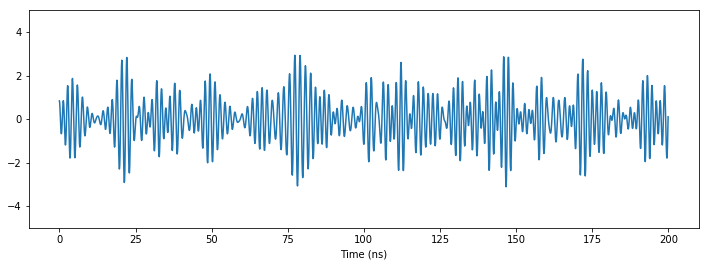

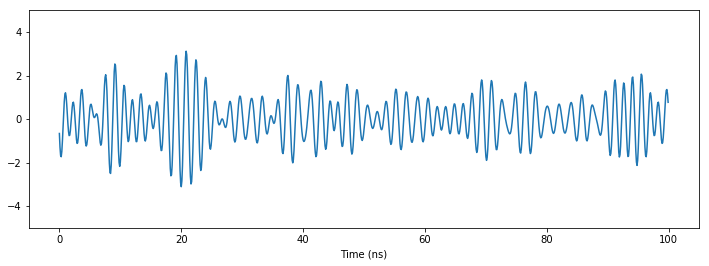

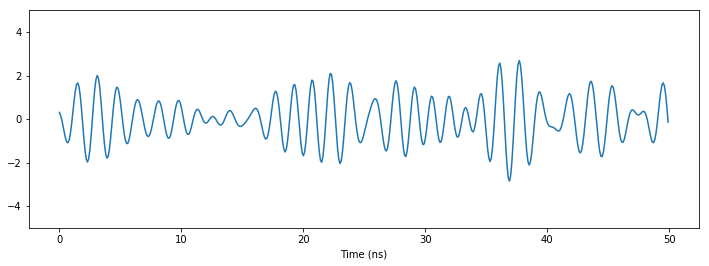

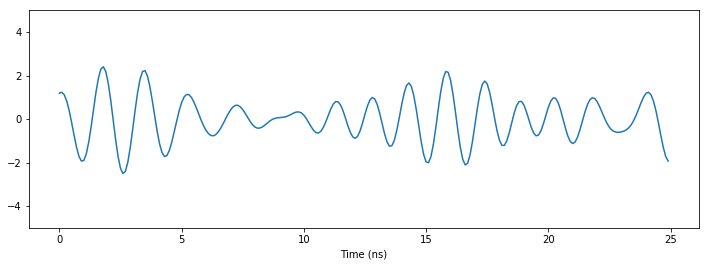

In [4]:
temp = 300
f_band = [500e6, 750e6]
# Calculate resistance to give v_rms=1 so amplitudes can be compared directly to ANITA paper
res = 1 / (4*1.38e-23*temp*(f_band[1]-f_band[0]))
dt = 0.1e-9

shape = (12,4)
noise1 = ThermalNoise(np.arange(2000)*dt, f_band, temperature=temp, resistance=res)
plot_sig(noise1, figsize=shape)
plt.axes().set_ylim(-5,5)

noise2 = ThermalNoise(np.arange(1000)*dt, f_band, temperature=temp, resistance=res)
plot_sig(noise2, figsize=shape)
plt.axes().set_ylim(-5,5)

noise3 = ThermalNoise(np.arange(500)*dt, f_band, temperature=temp, resistance=res)
plot_sig(noise3, figsize=shape)
plt.axes().set_ylim(-5,5)

noise4 = ThermalNoise(np.arange(250)*dt, f_band, temperature=temp, resistance=res)
plot_sig(noise4, figsize=shape)
plt.axes().set_ylim(-5,5)

long_noise = ThermalNoise(np.arange(100000)*dt, f_band, temperature=temp, resistance=res)

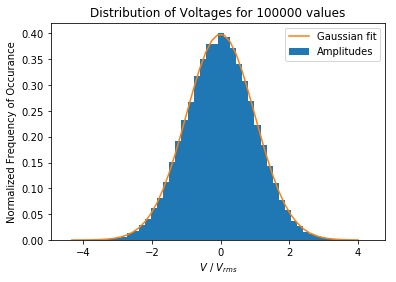

In [13]:
hist = plt.hist(long_noise.values, bins=50, normed=True, label="Amplitudes")
std_norm = lambda x: np.exp(-x**2 / 2) / np.sqrt(2*np.pi)
plt.plot(hist[1][1:-2], [std_norm(x) for x in hist[1][1:-2]], label="Gaussian fit")
plt.title("Distribution of Voltages for "+str(len(long_noise.values))+" values")
plt.xlabel(r"$V\ /\ V_{rms}$")
plt.ylabel("Normalized Frequency of Occurance")
plt.legend()
plt.show()

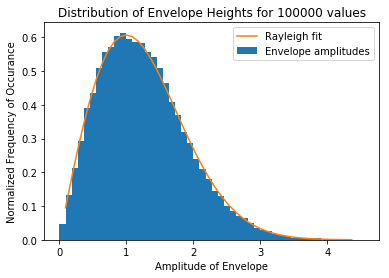

In [14]:
hist = plt.hist(long_noise.envelope, bins=50, normed=True, label="Envelope amplitudes")
rayleigh = lambda x: x * np.exp(-x**2 / 2)
plt.plot(hist[1][1:-2], [rayleigh(x) for x in hist[1][1:-2]], label="Rayleigh fit")
plt.title("Distribution of Envelope Heights for "+str(len(long_noise.values))+" values")
plt.xlabel("Amplitude of Envelope")
plt.ylabel("Normalized Frequency of Occurance")
plt.legend()
plt.show()

Test that setting rms_voltage works appropriately

In [15]:
set_rms_noise = ThermalNoise(np.arange(2000)*dt, f_band, rms_voltage=2.0)
for noise in [noise1, noise2, noise3, noise4, long_noise, set_rms_noise]:
    calculated_rms = np.sqrt(np.mean(noise.values**2))
    print(noise.rms,"=",calculated_rms)

1.0 = 0.998413460547
1.0 = 0.988398323411
1.0 = 0.983293780615
1.0 = 0.999519892595
1.0 = 0.999951885386
2.0 = 1.99942375362


Compare plots of noise generated using ``with_times`` method

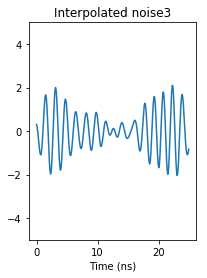

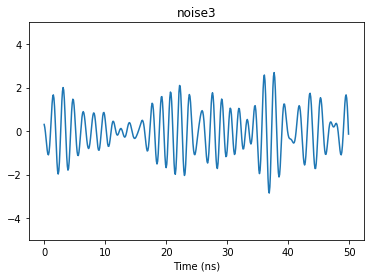

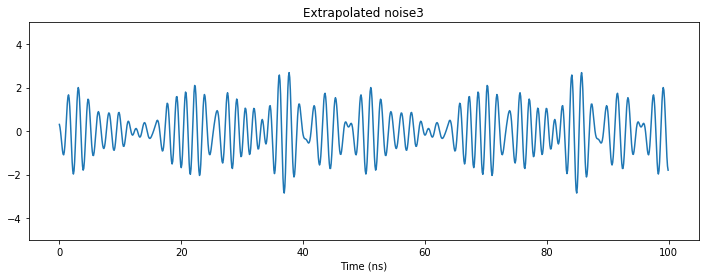

In [11]:
noise5 = noise3.with_times(np.arange(250)*dt)
noise6 = noise3.with_times(np.arange(1000)*dt)

shape5 = (3,4)
plot_sig(noise5, figsize=shape5)
plt.title("Interpolated noise3")
plt.axes().set_ylim(-5,5)
plt.show()

shape3 = (6,4)
plot_sig(noise3, figsize=shape3)
plt.title("noise3")
plt.axes().set_ylim(-5,5)
plt.show()

shape6 = (12,4)
plot_sig(noise6, figsize=shape6)
plt.title("Extrapolated noise3")
plt.axes().set_ylim(-5,5)
plt.show()

300 frequencies used


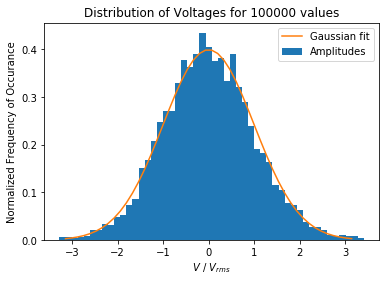

In [53]:
f_band = [100e6, 400e6]
dt = 0.1e-9

nonperiodic_noise = ThermalNoise(np.arange(1000)*dt, f_band, rms_voltage=1, n_freqs=300)
print(len(periodic_noise.freqs), "frequencies used")
# plot_sig(periodic_noise, figsize=(12,4))
# plt.show()

long_nonperiodic_noise = periodic_noise.with_times(np.arange(100000)*dt)
# plot_sig(longer_periodic_noise, figsize=(12,4))
# plt.show()

hist = plt.hist(long_nonperiodic_noise.values, bins=50, normed=True, label="Amplitudes")
std_norm = lambda x: np.exp(-x**2 / 2) / np.sqrt(2*np.pi)
plt.plot(hist[1][1:-2], [std_norm(x) for x in hist[1][1:-2]], label="Gaussian fit")
plt.title("Distribution of Voltages for "+str(len(long_nonperiodic_noise.values))+" values")
plt.xlabel(r"$V\ /\ V_{rms}$")
plt.ylabel("Normalized Frequency of Occurance")
plt.legend()
plt.show()

Compare plots of noise generated with different ``n_freq``s (at or above recommended amount) - look similar, which is good news

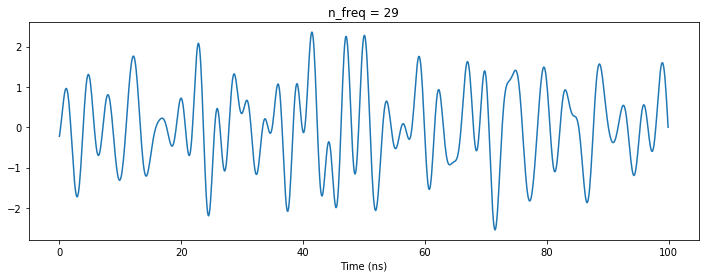

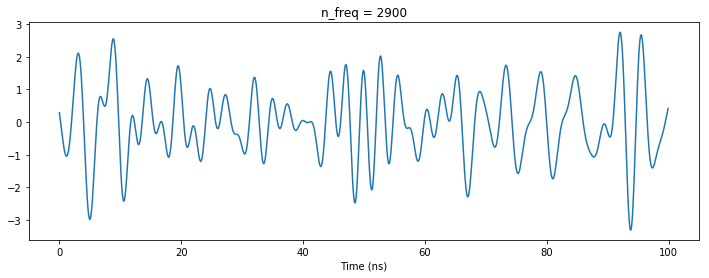

In [60]:
f_band = [100e6, 400e6]
dt = 0.1e-9

recommended_nfreq_noise = ThermalNoise(np.arange(1000)*dt, f_band, rms_voltage=1)
plot_sig(recommended_nfreq_noise, figsize=(12,4))
plt.title("n_freq = "+str(len(recommended_nfreq_noise.freqs)))
plt.show()

large_nfreq = len(recommended_nfreq_noise.freqs)*100
large_nfreq_noise = ThermalNoise(np.arange(1000)*dt, f_band, rms_voltage=1, n_freqs=large_nfreq)
plot_sig(large_nfreq_noise, figsize=(12,4))
plt.title("n_freq = "+str(len(large_nfreq_noise.freqs)))
plt.show()

<a id='dipole_antenna'></a>
# Test Dipole Antenna

In [16]:
dipole = pyrex.DipoleAntenna(name="ant", position=[0,0,-250], center_frequency=250e6,
                             bandwidth=300e6, resistance=100, trigger_threshold=5E-6)

Check the frequency response of the dipole antenna. Should be approximately 1 around 250 MHz and drop off (-3 dB point) around 100 and 400 MHz.

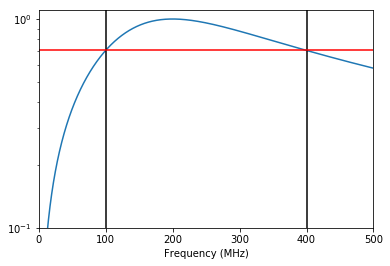

In [17]:
f_min = 0
f_max = 500
freq = np.linspace(f_min, f_max, (f_max-f_min)*100)
resp = dipole.response(freq*1e6)
plt.semilogy(freq, np.abs(resp))
plt.axvline(100, color="k")
plt.axvline(400, color="k")
plt.axhline(1/np.sqrt(2), color="r")
plt.xlabel("Frequency (MHz)")
plt.axis([f_min, f_max, 0.1, 1.1])
plt.show()

Check the directional gain of the dipole antenna. Should go like $\sin(\theta)$ and be independent of $\phi$.

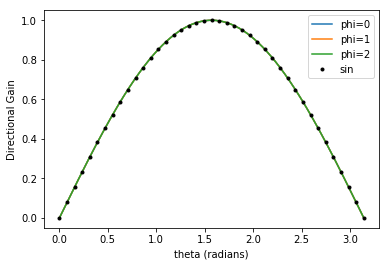

In [18]:
phis = [0, 1, 2]
thetas = np.linspace(0, np.pi, 1001)
for phi in phis:
    d_gains = [dipole.directional_gain(theta, phi) for theta in thetas]
    plt.plot(thetas, d_gains, label="phi="+str(phi))
thetas = thetas[::25]
plt.plot(thetas, np.sin(thetas), 'k.', label="sin")
plt.xlabel("theta (radians)")
plt.ylabel("Directional Gain")
plt.legend()
plt.show()

Check the polarization gain of the dipole antenna. Should go like $\sin(\theta)$ when polarized in the plane of the antenna and incoming ray. Should go like $\cos(\theta)$ when rotated about incoming ray, incoming at $90^\circ$

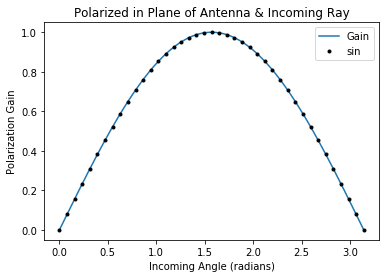

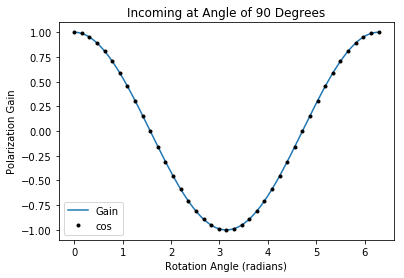

In [19]:
thetas = np.linspace(0, np.pi, 1001)
polarizations = [(np.cos(theta), 0, np.sin(theta)) for theta in thetas]
p_gains = [dipole.polarization_gain(pol) for pol in polarizations]
plt.plot(thetas, p_gains, label="Gain")
thetas = thetas[::25]
plt.plot(thetas, np.sin(thetas), 'k.', label="sin")
plt.title("Polarized in Plane of Antenna & Incoming Ray")
plt.xlabel("Incoming Angle (radians)")
plt.ylabel("Polarization Gain")
plt.legend()
plt.show()

thetas = np.linspace(0, 2*np.pi, 1001)
polarizations = [(0, np.sin(theta), np.cos(theta)) for theta in thetas]
p_gains = [dipole.polarization_gain(pol) for pol in polarizations]
plt.plot(thetas, p_gains, label="Gain")
thetas = thetas[::25]
plt.plot(thetas, np.cos(thetas), 'k.', label="cos")
plt.title("Incoming at Angle of 90 Degrees")
plt.xlabel("Rotation Angle (radians)")
plt.ylabel("Polarization Gain")
plt.legend()
plt.show()

<a id="reflected_logic"></a>
# Test ReflectedPathFinder Logic

In [3]:
class SplitPath(pyrex.ReflectedPathFinder):
    def get_bounce_point(self):
        return (self.to_point - self.from_point)/2 + self.from_point

    @property
    def exists(self):
        return self.path_1.exists and self.path_2.exists

In [4]:
pf1 = pyrex.PathFinder(ice_model=pyrex.IceModel(),
                       from_point=[100, 100, -500],
                       to_point=[15, 50, -100])
pf2 = SplitPath(ice_model=pf1.ice,
                from_point=pf1.from_point,
                to_point=pf1.to_point)

In [5]:
print(pf1.ice == pf2.ice)
print(pf1.from_point == pf2.from_point)
print(pf1.to_point == pf2.to_point)
print(pf2.from_point, pf2.bounce_point, pf2.to_point)

True
[ True  True  True]
[ True  True  True]
[ 100  100 -500] [  57.5   75.  -300. ] [  15   50 -100]


In [6]:
print(pf1.exists)
print(pf2.exists)

True
True


In [7]:
print(pf1.emitted_ray)
print(pf2.emitted_ray)

[-0.20632223 -0.12136602  0.97092813]
[-0.20632223 -0.12136602  0.97092813]


In [8]:
print(pf1.path_length)
print(pf2.path_length)

411.976941102
411.976941102


In [9]:
print(pf1.tof)
print(pf2.tof)

2.38390118516e-06
2.38390656733e-06


In [10]:
print(pf1.time_of_flight(n_steps=49))
print(pf2.time_of_flight(n_steps=25))

2.38387783881e-06
2.38387783881e-06


In [11]:
print(pf1.attenuation([1e3, 1e6, 1e9]))
print(pf2.attenuation([1e3, 1e6, 1e9]))

[ 0.99724377  0.97012381  0.71653209]
[ 0.99724484  0.97013465  0.71661489]


In [12]:
print(pf1.attenuation([1e3, 1e6, 1e9], n_steps=49))
print(pf2.attenuation([1e3, 1e6, 1e9], n_steps=25))

[ 0.99724153  0.97010123  0.71635954]
[ 0.99724162  0.97010212  0.71636632]


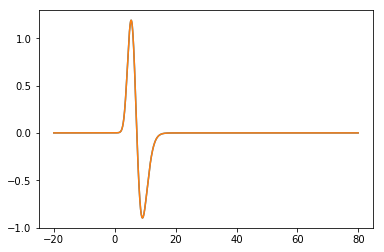

In [13]:
times = np.linspace(-20e-9, 80e-9, 2048, endpoint=False)
pulse1 = pyrex.AskaryanSignal(times=times, energy=1e9, theta=np.radians(45), n=1.75)
pulse2 = pyrex.Signal(pulse1.times, pulse1.values, value_type=pulse1.value_type)
plt.plot(pulse1.times*1e9, pulse1.values)
plt.plot(pulse2.times*1e9, pulse2.values)
plt.show()

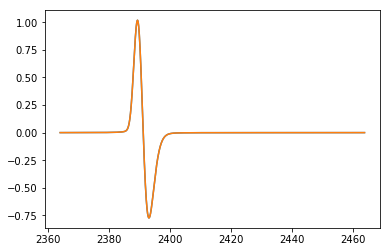

In [14]:
pf1.propagate(pulse1)
pf2.propagate(pulse2)
plt.plot(pulse1.times*1e9, pulse1.values)
plt.plot(pulse2.times*1e9, pulse2.values)
plt.show()

<a id="reflected_path"></a>
# Test ReflectedPathFinder Paths

In [3]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

<IPython.core.display.Javascript object>


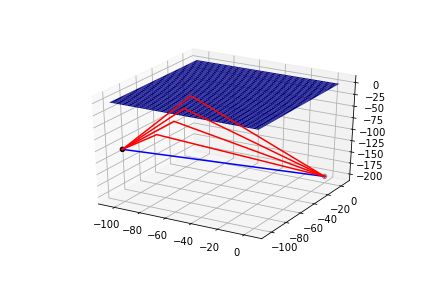

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

pf = pyrex.PathFinder(ice_model=pyrex.IceModel(),
                      from_point=[0, 0, -200],
                      to_point=[-100, -100, -100])

ax.scatter([pf.from_point[0], pf.to_point[0]], 
           [pf.from_point[1], pf.to_point[1]],
           [pf.from_point[2], pf.to_point[2]],
           c="k")

ax.plot([pf.from_point[0], pf.to_point[0]], 
        [pf.from_point[1], pf.to_point[1]],
        [pf.from_point[2], pf.to_point[2]],
        c="b" if pf.exists else "r")


bounce_depths = np.linspace(pf.to_point[2], 0, num=5)[1:]

for depth in bounce_depths:
    rpf = pyrex.ReflectedPathFinder(ice_model=pyrex.IceModel(),
                                    from_point=pf.from_point,
                                    to_point=pf.to_point,
                                    reflection_depth=depth)

    ax.plot([rpf.from_point[0], rpf.bounce_point[0], rpf.to_point[0]], 
            [rpf.from_point[1], rpf.bounce_point[1], rpf.to_point[1]],
            [rpf.from_point[2], rpf.bounce_point[2], rpf.to_point[2]],
            c="b" if rpf.exists else "r")

# xlim = ax.get_xlim()
# ylim = ax.get_ylim()
# zlim = ax.get_zlim()

# ax.set_xlim(min(xlim[0], ylim[0], zlim[0]), max(xlim[1], ylim[1], zlim[1]))
# ax.set_ylim(ax.get_xlim())
# ax.set_zlim(ax.get_xlim())

xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1]), np.linspace(ylim[0], ylim[1]))
zz = xx*0

ax.plot_surface(xx, yy, zz, color='b')

plt.show()

In [8]:
u1 = rpf.bounce_point - rpf.from_point
d1 = np.array([u1[0], u1[1], 0])
cosphi1 = np.dot(u1, d1)/np.linalg.norm(u1)/np.linalg.norm(d1)
print("phi1 =", np.degrees(np.arccos(cosphi1)))

u2 = rpf.bounce_point - rpf.to_point
d2 = np.array([u2[0], u2[1], 0])
cosphi2 = np.dot(u2, d2)/np.linalg.norm(u2)/np.linalg.norm(d2)
print("phi2 =", np.degrees(np.arccos(cosphi2)))

print("direct path exists =", pf.exists)
print("reflected path exists =", rpf.exists)

phi1 = 42.1782760948
phi2 = 42.1782760948
direct path exists = False
reflected path exists = True


In [9]:
%matplotlib inline